In [1]:
library("rjags")

Loading required package: coda
Linked to JAGS 3.4.0
Loaded modules: basemod,bugs


###Normal mixture model

1/sd1^2: 1       1/sd2^2: 4
mean1: 0.969585259978715sd1: 1.01770581112943


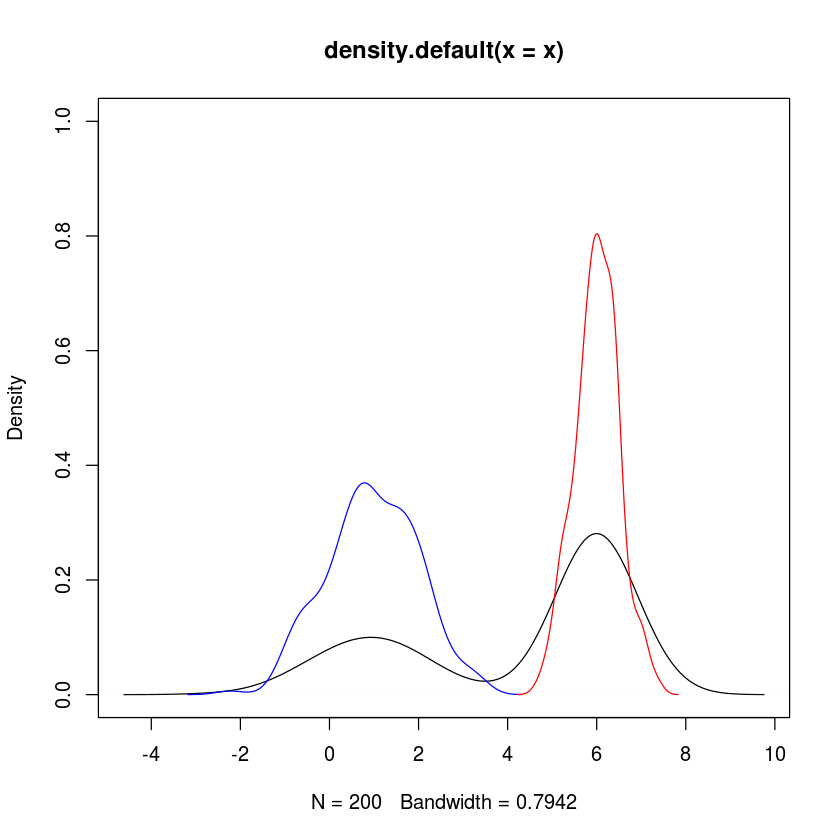

In [2]:
##Create two normal components

mu1 <- 1
sd1 <- 1
mu2 <- 6
sd2 <- 0.5

message("1/sd1^2: ", 1/sd1^2, '       1/sd2^2: ', 1/sd2^2)
NN <- 200
x1 <- rnorm(NN, mu1, sd1)

message("mean1: ", mean(x1), "sd1: ", sd(x1))
x2 <- rnorm(NN, mu2, sd2)

pi0 <- 0.3 #Mixing proportion

xy <- cbind(x1, x2)

x <- apply(xy, 1, function(xChoose) sample(xChoose, 1, prob = c(pi0, 1 - pi0)))

plot(density(x), ylim = c(0, 1))
    
    lines(density(x1), col = 'blue')
    
    lines(density(x2), col = 'red')

In [7]:
###Write a model in jags code

dataJags <- list(x = x, 
                   NN = NN,
                    alpha0 = c(1, 1) ##Prior information for the latent catogorical variables
                   )

###Use latent catogorical variables

In [36]:
jagsFile = "model{
    for (i in 1:NN){
        x[i] ~ dnorm(mux[i], taux[i])
        mux[i] <- mu0[T[i]]
        taux[i] <- (1/sd0[T[i]])^2 
        T[i] ~ dcat(p1[]) 
    }
    
    p1[1:2] ~ ddirch(alpha0)
    mu0[1] ~ dunif(0, 3)
    mu0[2] ~ dunif(2, 10)
    sd0[1] ~ dnorm(1, 0.1)
    sd0[2] ~ dnorm(0.5, 0.1)I(0, )
}"

In [41]:
n.chains = 1
n.adapt = 100
        
mixture <- jags.model(textConnection(jagsFile),# inits = inits,
                              data = dataJags, n.chains = n.chains, n.adapt = n.adapt)



Compiling model graph
   Resolving undeclared variables
   Allocating nodes
   Graph Size: 1216

Initializing model



In [42]:
nUpdate = 2000
update(mixture, nUpdate)



In [43]:
n.iter = 5000
thin = 5
xem <- coda.samples(mixture, c('mu0', 'sd0', 'p1'),
                    n.iter = n.iter, thin = thin)

In [44]:
outMCMC <- xem[[1]]


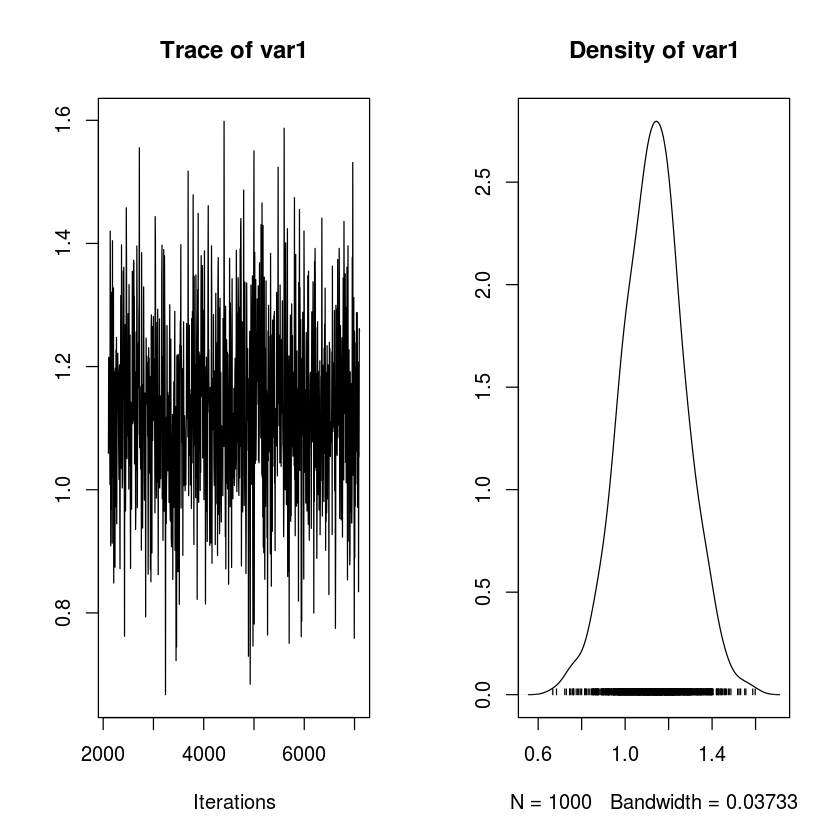

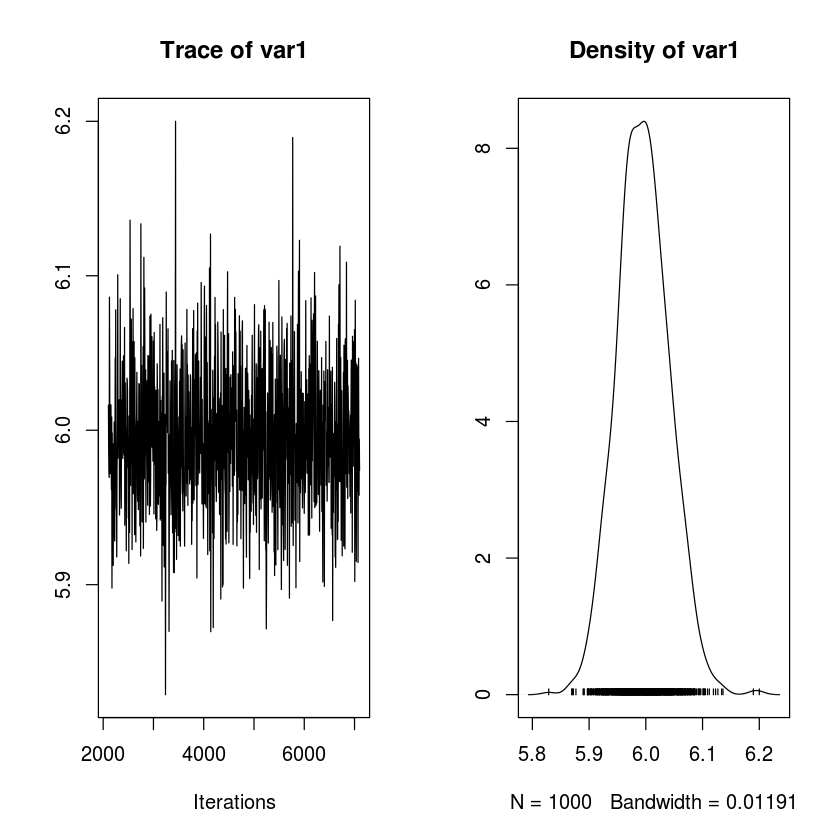

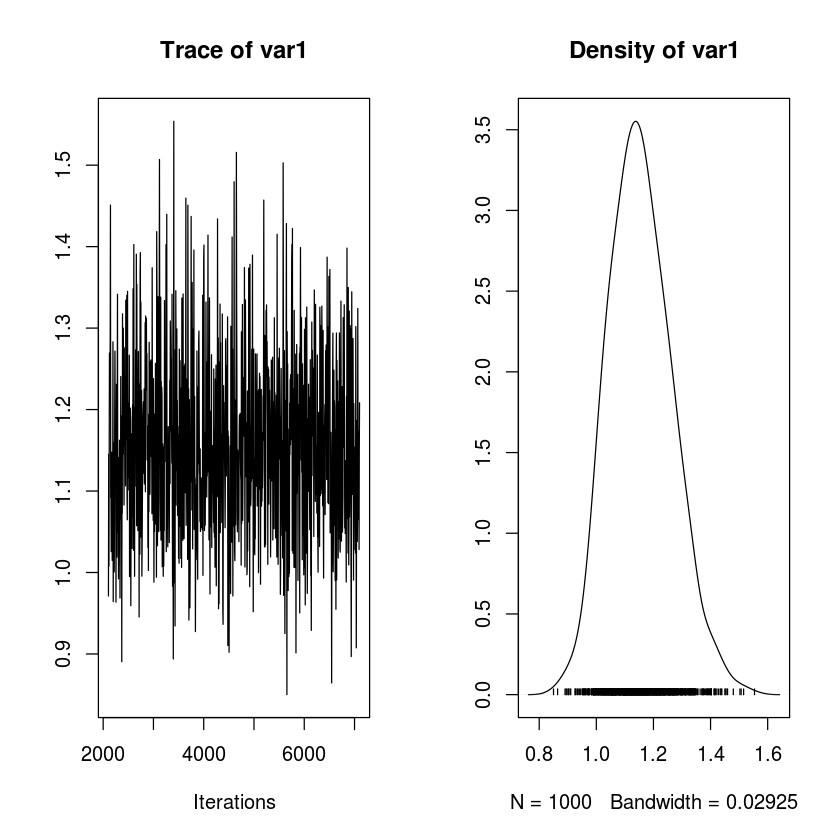

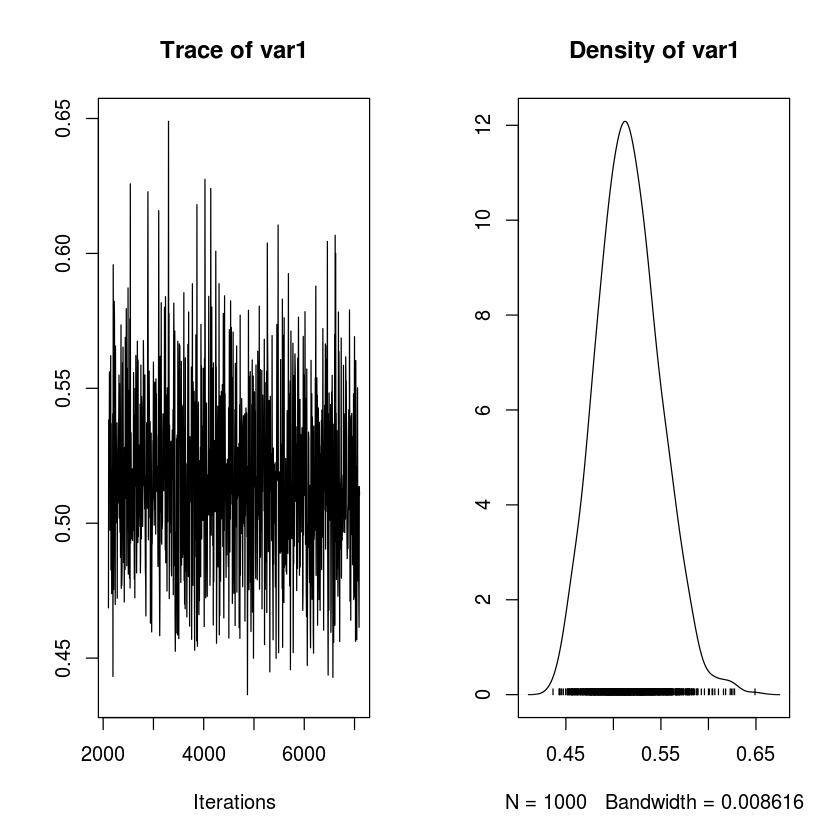

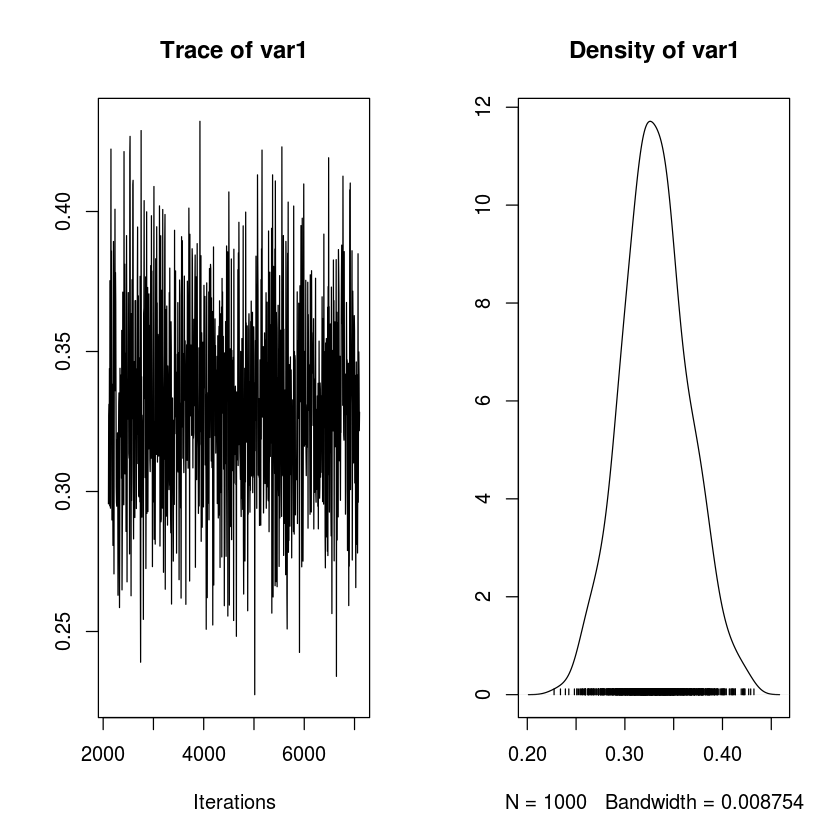

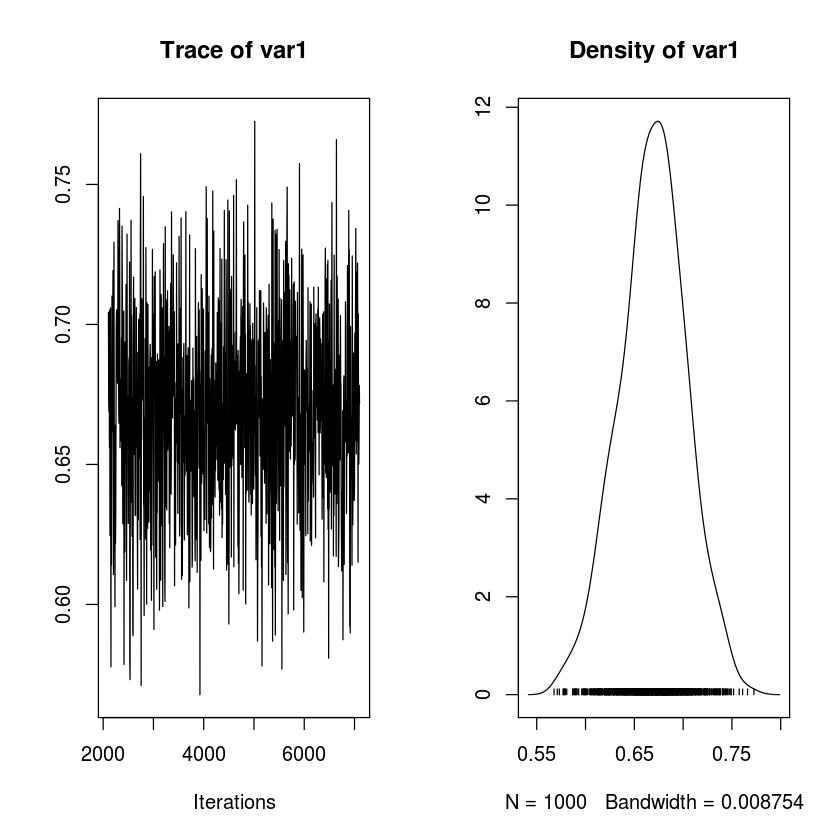

In [45]:

plot(outMCMC[, 'mu0[1]'])
plot(outMCMC[, 'mu0[2]'])
plot(outMCMC[, 'sd0[1]'])
plot(outMCMC[, 'sd0[2]'])
plot(outMCMC[, 'p1[1]'])
plot(outMCMC[, 'p1[2]'])

In [46]:
bb <- apply(outMCMC, 2, mean)

In [47]:
bb

mu0[1]    mu0[2]     p1[1]     p1[2]    sd0[1]    sd0[2] 
1.1308303 5.9955850 0.3311163 0.6688837 1.1553937 0.5165190

In [57]:
!gist -p mixture_models_wth_rjags.ipynb

ERROR: Error in parse(text = x, srcfile = src): <text>:1:10: unexpected symbol
1: !gist -p mixture_models_wth_rjags.ipynb
             ^


###Use binomial distribution

In [5]:
jagsFile = "model{
    for (i in 1:NN){
        groupI[i] ~ dbern(p1) ##Choose a group
        inDex[i] <- groupI[i] + 1 ##Move 0-1 to 1-2

        x[i] ~ dnorm(mux[i], taux[i]) ##Samping the data
        mux[i] <- mu0[inDex[i]]
        taux[i] <- (1/sd0[inDex[i]])^2 
        
    }
    
    p1 ~ dunif(0, 1)
    mu0[1] ~ dunif(0, 3)
    mu0[2] ~ dunif(2, 10)
    sd0[1] ~ dnorm(1, 0.1)
    sd0[2] ~ dnorm(0.5, 0.1)I(0, )
}"

In [9]:
n.chains = 1
n.adapt = 100
        
mixture <- jags.model(textConnection(jagsFile),# inits = inits,
                              data = dataJags, n.chains = n.chains, n.adapt = n.adapt)




Warning message:
In jags.model(textConnection(jagsFile), data = dataJags, n.chains = n.chains, : Unused variable "alpha0" in data

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
   Graph Size: 1413

Initializing model



In [10]:
nUpdate = 2000
update(mixture, nUpdate)

In [16]:
n.iter = 10000
thin = 5
xem <- coda.samples(mixture, c('mu0', 'sd0', 'p1'),
                    n.iter = n.iter, thin = thin)

In [17]:
outMCMC <- xem[[1]]

dim(outMCMC)

[1] 2000    5

In [18]:
apply(outMCMC, 2, mean)

mu0[1]    mu0[2]        p1    sd0[1]    sd0[2] 
0.8816579 5.9961675 0.6572789 1.1223494 0.5081992

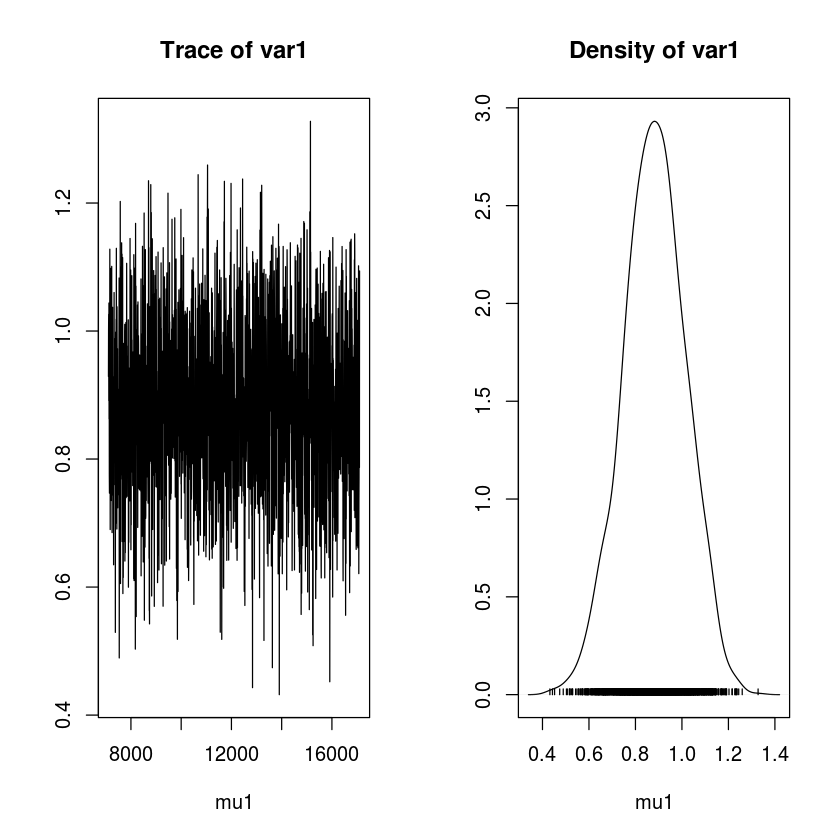

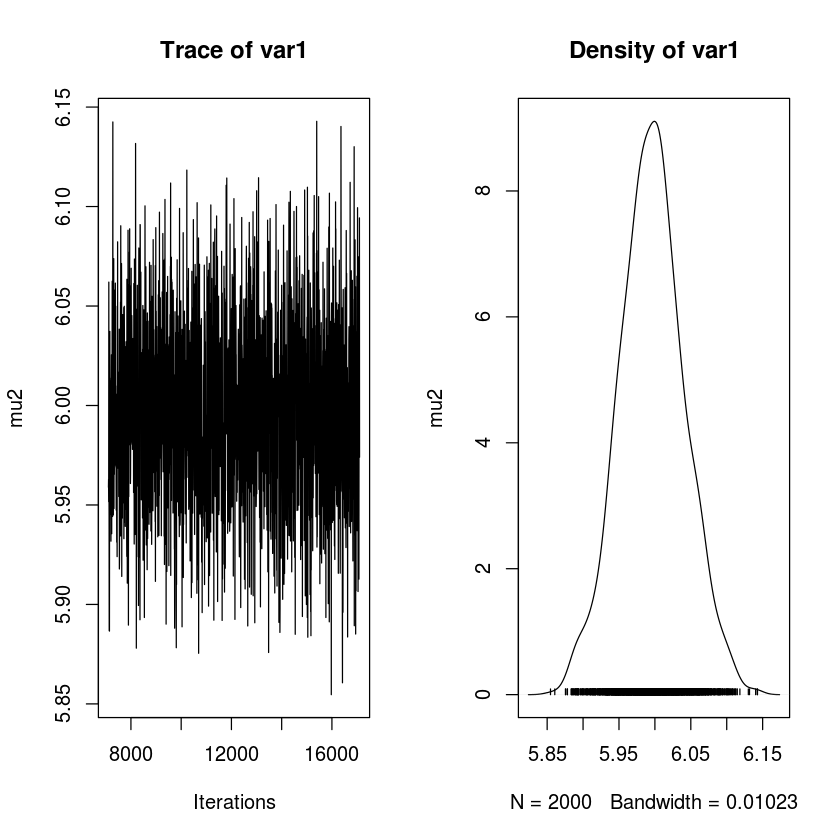

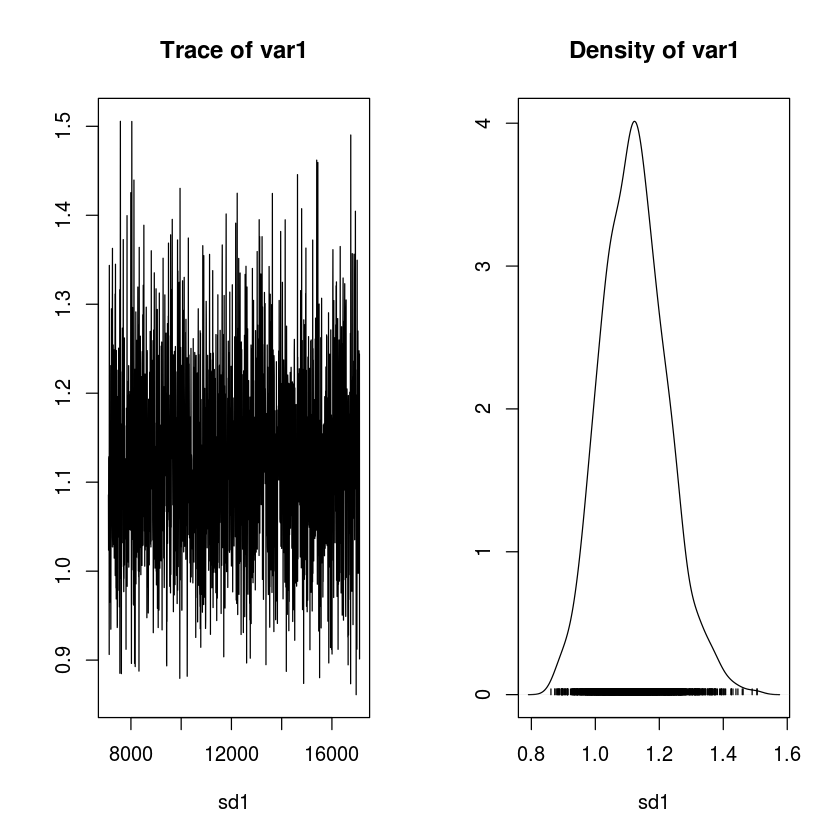

ERROR: Error in trace + density: non-numeric argument to binary operator


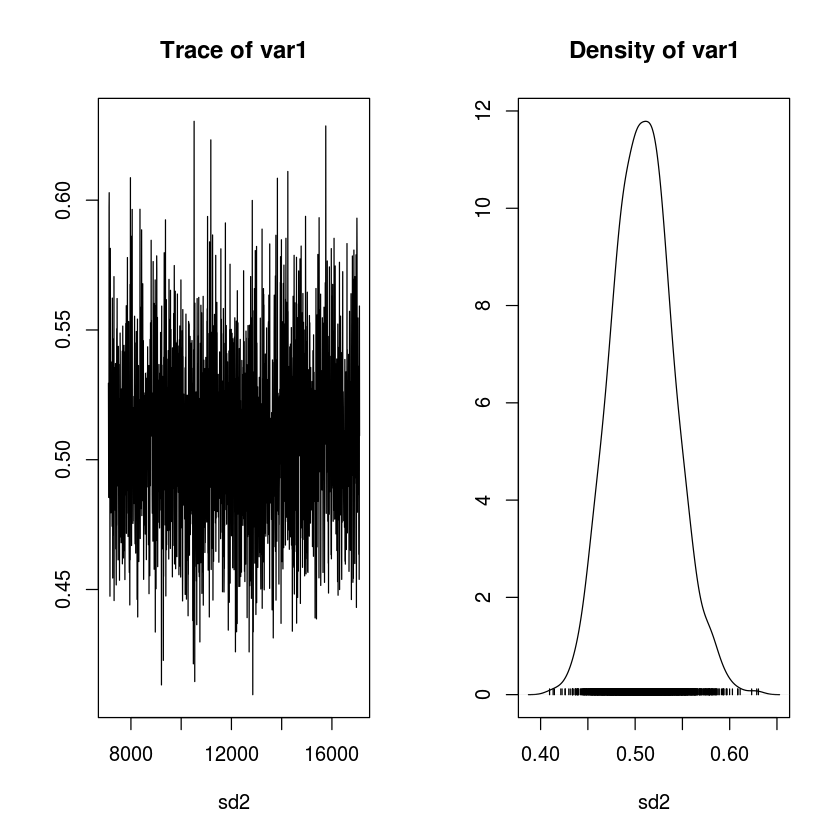

In [20]:
plot(outMCMC[, 'mu0[1]'], xlab = 'mu1')
plot(outMCMC[, 'mu0[2]'], ylab = 'mu2')
plot(outMCMC[, 'sd0[1]'], xlab = 'sd1')
plot(outMCMC[, 'sd0[2]'], xlab = 'sd2')
plot(outMCMC[, 'p1'], 'pi')
